# 数据建模
## 当在调试环境中运行时
使用`保险数据集-训练 `抽样数据进行训练
使用`保险数据集-c测试 `抽样数据进行测试
## 当在全量环境中运行时
使用`保险数据集-训练 `全量数据进行训练
使用`保险数据集-c测试 `全量数据进行测试

### 构建baseline模型，Quadratic_Weighted_Kappa指标值为0.612

In [1]:
#导入必要的包

#计算与可视化
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

#评估指标、编码与模型
from  sklearn.metrics import accuracy_score,  auc, confusion_matrix, roc_auc_score, classification_report,cohen_kappa_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import xgboost as xgb
from scipy.optimize import fmin_powell
#from ml_metrics import quadratic_weighted_kappa

from wf_analyse.analyse import base

# 查看数据
## 字段说明：
* Ins_Age：申请人年龄（标准化处理过的结果）
* Ht：申请人身高（标准化处理过的结果）
* Wt：申请人体重（标准化处理过的结果）
* BMI：申请人身体健康指数（标准化处理过的结果）
* Product_Info_1-7：申请产品相关的变量（处理后的结果）
* Employment_Info_1-6：有关申请人工作经验的变量（处理后的结果）
* InsuredInfo_1-6：有关申请人的信息变量（处理后的结果）
* Insurance_History_1-9：有关申请人过去的保险信息（处理后的结果）
* Family_Hist_1-5:有关申请人家庭相关的信息（处理后的结果）
* Medical_History_1-41：有关申请人的医疗史信息（处理后的结果）
* Medical_Keyword_1-48：与该保险相关或不相关的医疗信息？？？不太确定含义，该信息是伪变量
* Response：响应值（1-8级：1，2，3，4，5，6，7，8）

## 字段类型说明：
* 连续值变量：
<p> Product_Info_4, Ins_Age, Ht, Wt, BMI, Employment_Info_1, Employment_Info_4, Employment_Info_6, Insurance_History_5, Family_Hist_2, Family_Hist_3, Family_Hist_4, Family_Hist_5.<p> 

* 离散值变量：
<p> Medical_History_1, Medical_History_10, Medical_History_15, Medical_History_24, Medical_History_32
Medical_Keyword_1-48 are dummy variables.<p> 

* 无序的类别变量：
<p> Product_Info_1, Product_Info_2, Product_Info_3, Product_Info_5, Product_Info_6, Product_Info_7, Employment_Info_2, Employment_Info_3, Employment_Info_5, InsuredInfo_1, InsuredInfo_2, InsuredInfo_3, InsuredInfo_4, InsuredInfo_5, InsuredInfo_6, InsuredInfo_7, Insurance_History_1, Insurance_History_2, Insurance_History_3, Insurance_History_4, Insurance_History_7, Insurance_History_8, Insurance_History_9, Family_Hist_1, Medical_History_2, Medical_History_3, Medical_History_4, Medical_History_5, Medical_History_6, Medical_History_7, Medical_History_8, Medical_History_9, Medical_History_11, Medical_History_12, Medical_History_13, Medical_History_14, Medical_History_16, Medical_History_17, Medical_History_18, Medical_History_19, Medical_History_20, Medical_History_21, Medical_History_22, Medical_History_23, Medical_History_25, Medical_History_26, Medical_History_27, Medical_History_28, Medical_History_29, Medical_History_30, Medical_History_31, Medical_History_33, Medical_History_34, Medical_History_35, Medical_History_36, Medical_History_37, Medical_History_38, Medical_History_39, Medical_History_40, Medical_History_41

In [2]:
# 导入数据集 保险数据集-训练
 
import wfio
_INPUT = '{"type":15,"uri":"awss32d9f105f22ab411298cdd6462cc2ee1d/sd_5629997fec4649668cd83bbd83aa03ba"}'
 
# 读取并返回对应的Dataframe
# 参数as_spark: 为True返回Spark DataFrame，为False返回Pandas DataFrame，默认为False 
train = wfio.read_dataframe(_INPUT,as_spark = False)

In [3]:
# 导入数据集 保险数据集-测试-抽样
 
import wfio
_INPUT2 = '{"type":15,"uri":"awss3bbbfe5c8f0704f05b61aa304dde4ae74/sd_2de4c41af9b24ea3969f0a9537af7386"}'
 
# 读取并返回对应的Dataframe
# 参数as_spark: 为True返回Spark DataFrame，为False返回Pandas DataFrame，默认为False 
test = wfio.read_dataframe(_INPUT2,as_spark = False)

In [4]:
#查看训练集数据情况
print(train.info())  #"Product_Info_2是"object"类型的数据，其他字段均是数值型
print(train.columns)
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4157 entries, 0 to 4156
Columns: 134 entries, empty_name to response
dtypes: float64(19), int64(109), object(6)
memory usage: 4.2+ MB
None
Index(['empty_name', 'name', 'sex', 'id_card', 'mobile_number', 'email',
       'addr', 'product_info_1', 'product_info_2', 'product_info_3',
       ...
       'medical_keyword_40', 'medical_keyword_41', 'medical_keyword_42',
       'medical_keyword_43', 'medical_keyword_44', 'medical_keyword_45',
       'medical_keyword_46', 'medical_keyword_47', 'medical_keyword_48',
       'response'],
      dtype='object', length=134)


,empty_name,name,sex,id_card,mobile_number,email,addr,product_info_1,product_info_2,product_info_3,...,medical_keyword_40,medical_keyword_41,medical_keyword_42,medical_keyword_43,medical_keyword_44,medical_keyword_45,medical_keyword_46,medical_keyword_47,medical_keyword_48,response
0,0,孙*,女,**************173X,1721258****,NaN,福建省莆********-**-*****,1,D4,26,...,0,0,0,0,0,0,0,0,0,6
1,2,陆昌*,男,**************3850,1827906****,NaN,广东省梅*********-**-****,1,A8,10,...,1,0,0,0,0,0,0,0,0,1
2,3,陈*,男,**************3750,1327455****,NaN,广东省珠**********-**-***,2,D4,26,...,0,0,0,0,0,0,0,0,0,8
3,4,周凡*,女,**************1925,1523119****,NaN,广东省揭**********-*-****,1,D3,26,...,0,0,0,0,0,0,0,0,0,6
4,5,李*,女,**************5522,1714197****,NaN,浙江省*********-*-***-**,1,D2,26,...,0,0,0,0,0,0,0,0,0,3


In [5]:
#查看测试集数据情况
test.info()
test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1782 entries, 0 to 1781
Columns: 134 entries, empty_name to response
dtypes: float64(19), int64(109), object(6)
memory usage: 1.8+ MB


,empty_name,name,sex,id_card,mobile_number,email,addr,product_info_1,product_info_2,product_info_3,...,medical_keyword_40,medical_keyword_41,medical_keyword_42,medical_keyword_43,medical_keyword_44,medical_keyword_45,medical_keyword_46,medical_keyword_47,medical_keyword_48,response
0,0,彭*,女,**************852X,1857993****,NaN,北京市朝*********-*-*****,1,D3,26,...,0,0,0,0,0,0,0,0,0,5
1,2,周*,男,**************941X,1490961****,NaN,北京市************-**-*,1,A8,26,...,0,0,0,0,0,0,0,0,0,6
2,3,于*,女,**************2157,1473740****,NaN,广东省*********-*-***-**,1,D3,26,...,0,0,0,0,0,0,0,0,0,6
3,4,周*,男,**************2033,1590059****,NaN,云南省保**********-*-****,1,B2,29,...,0,0,0,0,0,0,0,0,0,8
4,5,王*,男,**************3658,1533579****,NaN,广东省茂*********-**-****,1,D4,26,...,0,0,0,0,0,0,0,0,0,1


In [6]:
#计算Quadratic_Weighted_Kappa指标值
def eval_wrapper(yhat, y):  
    y = np.array(y)
    y = y.astype(int)
    yhat = np.array(yhat)
    yhat = np.clip(np.round(yhat), np.min(y), np.max(y)).astype(int)   
    return cohen_kappa_score(yhat, y, weights= 'quadratic')

#计算准确率Accuracy
def acc(y, yhat):  
    y = np.array(y)
    y = y.astype(int)
    yhat = np.array(yhat)
    yhat = np.clip(np.round(yhat), np.min(y), np.max(y)).astype(int)   
    return accuracy_score(y, yhat)

In [7]:
# 全局变量
columns_to_drop = ['response']
xgb_num_rounds = 700
num_classes = 8

In [8]:
test_label = test["response"].copy()
test["response"] = -1000
# 将训练集与测试集拼接，并于统一特征处理
all_data = train.append(test)

In [9]:
#删除无用字段特征
all_data.drop(["empty_name", 'name', "sex", "id_card","mobile_number", "email", "addr"], axis = 1, inplace=True)

In [10]:
## 增加特征
all_data['bmi_wt'] = all_data['bmi'] * all_data['wt']

In [11]:
# 创建新特征 
# 特征编码
all_data['product_info_2'] = pd.factorize(all_data['product_info_2'])[0]

print('Eliminate missing values')    
# 空值填充-1
all_data.fillna(-1, inplace=True)

# 将label转为int值
all_data['response'] = all_data['response'].astype(int)

Eliminate missing values


In [12]:
def get_params():
    params = {}
    params["objective"] = "reg:linear"     
    params["eta"] = 0.05
    params["min_child_weight"] = 50
    params["subsample"] = 0.8
    params["colsample_bytree"] = 0.30
    params["silent"] = 1
    params["max_depth"] = 8
    plst = list(params.items())
    return plst

In [13]:
# 拆分数据集
train = all_data[all_data['response']>0].copy()
test = all_data[all_data['response']<1].copy()

In [14]:
# 转成xgb格式
xgtrain = xgb.DMatrix(train.drop(columns_to_drop, axis=1), train['response'].values)
xgtest = xgb.DMatrix(test.drop(columns_to_drop, axis=1), label=test_label.values)

# 获取模型参数
plst = get_params()

In [15]:
evals_process = dict()   #存储训练过程中的指标，便于后面loss曲线图

In [16]:
model = xgb.train(plst, xgtrain, xgb_num_rounds,evals=[(xgtrain, 'train'),(xgtest,'test')],verbose_eval=50, evals_result = evals_process)
#每50轮打印一次结果

[0]	train-rmse:5.41012	test-rmse:5.50101
[50]	train-rmse:1.88067	test-rmse:1.97457
[100]	train-rmse:1.69074	test-rmse:1.85398
[150]	train-rmse:1.59555	test-rmse:1.84293
[200]	train-rmse:1.51960	test-rmse:1.84044
[250]	train-rmse:1.45015	test-rmse:1.84517
[300]	train-rmse:1.38724	test-rmse:1.85293
[350]	train-rmse:1.32839	test-rmse:1.86045
[400]	train-rmse:1.27112	test-rmse:1.86671
[450]	train-rmse:1.21912	test-rmse:1.86990
[500]	train-rmse:1.17011	test-rmse:1.87665
[550]	train-rmse:1.12571	test-rmse:1.88129
[600]	train-rmse:1.08642	test-rmse:1.88571
[650]	train-rmse:1.04611	test-rmse:1.89094
[699]	train-rmse:1.01100	test-rmse:1.89463


In [17]:
len(evals_process['train']["rmse"])   #训练了700个epoch

700

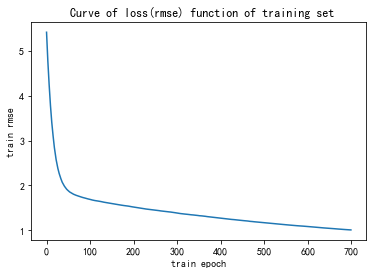

In [18]:
#绘制训练集的训练过程中的loss曲线图
epoch = []  # 横坐标,迭代次数
for i in range(0, xgb_num_rounds, 1):
    epoch.append(i)

plt.plot(epoch, evals_process['train']["rmse"])
plt.ylabel('train rmse')
plt.xlabel('train epoch')
plt.title(" Curve of loss(rmse) function of training set")
plt.show()

In [19]:
#保存训练集在训练过程中的loss值，用于绘制loss变化曲线图
for i in range(0, xgb_num_rounds, 1):
    base.save_norm_by_step(model_name='train', norm_name='loss',norm_value=np.float(evals_process['train']["rmse"][i]),step=i)
    #print(evals_process['train']["rmse"][i])

norm validate success,begin saving...
access token is None, skipping transforming.
norm validate success,begin saving...
access token is None, skipping transforming.
norm validate success,begin saving...
access token is None, skipping transforming.
norm validate success,begin saving...
access token is None, skipping transforming.
norm validate success,begin saving...
access token is None, skipping transforming.
norm validate success,begin saving...
access token is None, skipping transforming.
norm validate success,begin saving...
access token is None, skipping transforming.
norm validate success,begin saving...
access token is None, skipping transforming.
norm validate success,begin saving...
access token is None, skipping transforming.
norm validate success,begin saving...
access token is None, skipping transforming.
norm validate success,begin saving...
access token is None, skipping transforming.
norm validate success,begin saving...
access token is None, skipping transforming.
norm

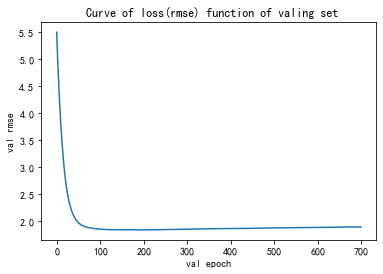

In [20]:
#绘制验证集在训练过程中的loss曲线图
epoch = []  # 横坐标,迭代次数
for i in range(0, xgb_num_rounds, 1):
    epoch.append(i)

plt.plot(epoch, evals_process['test']["rmse"])
# plt.plot([1,3,3,4], [1,4,9,16])
plt.ylabel('val rmse')
plt.xlabel('val epoch')
plt.title(" Curve of loss(rmse) function of valing set")
plt.show()

In [21]:
#全量数据保存
#保存测试集集在训练过程中的loss值，用于绘制loss变化曲线图
for i in range(0, xgb_num_rounds, 1):
    base.save_norm_by_step(model_name='validation', norm_name='loss',norm_value=np.float(evals_process['test']["rmse"][i]),step=i)
    #print(evals_process['test']["rmse"][i]

norm validate success,begin saving...
access token is None, skipping transforming.
norm validate success,begin saving...
access token is None, skipping transforming.
norm validate success,begin saving...
access token is None, skipping transforming.
norm validate success,begin saving...
access token is None, skipping transforming.
norm validate success,begin saving...
access token is None, skipping transforming.
norm validate success,begin saving...
access token is None, skipping transforming.
norm validate success,begin saving...
access token is None, skipping transforming.
norm validate success,begin saving...
access token is None, skipping transforming.
norm validate success,begin saving...
access token is None, skipping transforming.
norm validate success,begin saving...
access token is None, skipping transforming.
norm validate success,begin saving...
access token is None, skipping transforming.
norm validate success,begin saving...
access token is None, skipping transforming.
norm

In [22]:
train_preds = model.predict(xgtrain, ntree_limit=model.best_iteration)
print('Train kappa score is:', eval_wrapper(train_preds, train['response']))
print('Train accuracy score is:', acc(train["response"], train_preds))

test_preds = model.predict(xgtest, ntree_limit=model.best_iteration)
print('Test kappa score is:', eval_wrapper( test_preds, test_label))

Train kappa score is: 0.890134631800418
Train accuracy score is: 0.4423863363002165
Test kappa score is: 0.5896691759870196


In [23]:
#全量数据指标保存
#base.save_norm(model_name='xgbregression', norm_name='auc',norm_value=np.float(acc(train["response"], train_preds)), operate_type='train')   
#base.save_norm(model_name='xgbregression', norm_name='Quadratic_Weighted_Kappa',norm_value=np.float(eval_wrapper(train_preds, train['response'])), operate_type='train')              
base.save_norm(model_name='xgbregression', norm_name='Quadratic_Weighted_Kappa',norm_value=np.float(eval_wrapper( test_preds, test_label)), operate_type='test')           

norm validate success,begin saving...
access token is None, skipping transforming.
